In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv")

In [3]:
print(df.head())

   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520


In [4]:
df_encoded = pd.get_dummies(df, drop_first=True)

# Save charges separately for analysis
charges = df_encoded['charges']
X = df_encoded.drop('charges', axis=1)

# Scale numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [5]:
# Elbow method to find best K
sse = []
sil_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(X_scaled, kmeans.labels_))

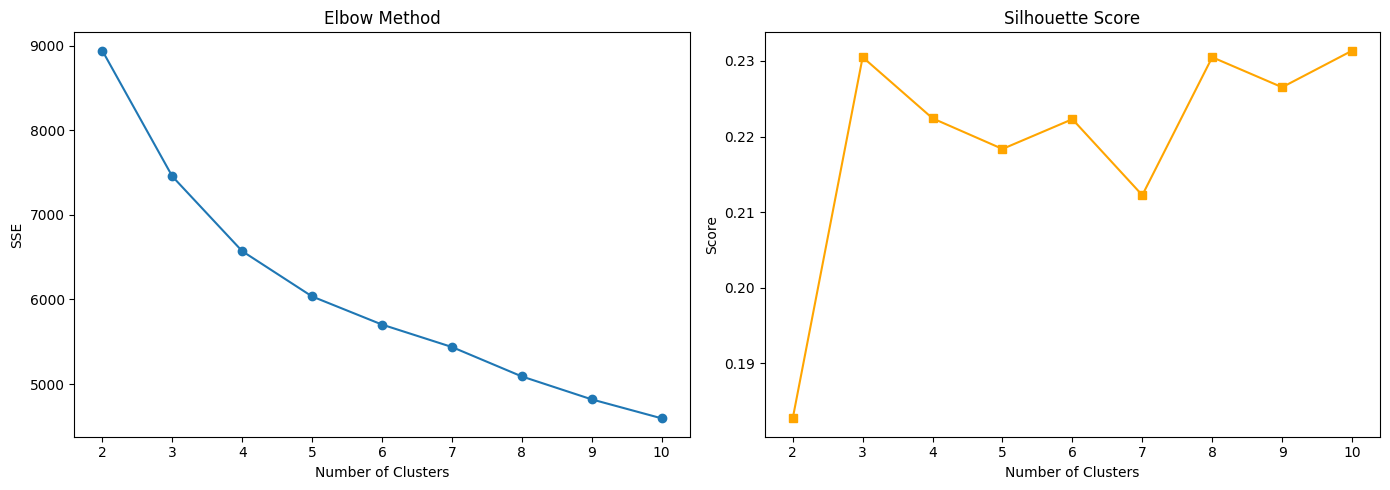

In [6]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(K_range, sse, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')

plt.subplot(1, 2, 2)
plt.plot(K_range, sil_scores, marker='s', color='orange')
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.tight_layout()
plt.show()

In [7]:
kmeans_final = KMeans(n_clusters=4, random_state=42, n_init=10)
df_encoded['Cluster_KMeans'] = kmeans_final.fit_predict(X_scaled)

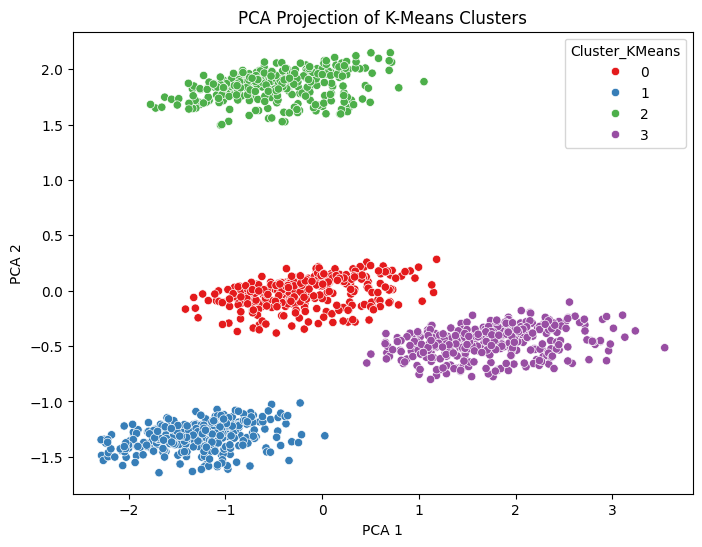

In [8]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df_encoded['Cluster_KMeans'], palette='Set1')
plt.title('PCA Projection of K-Means Clusters')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()


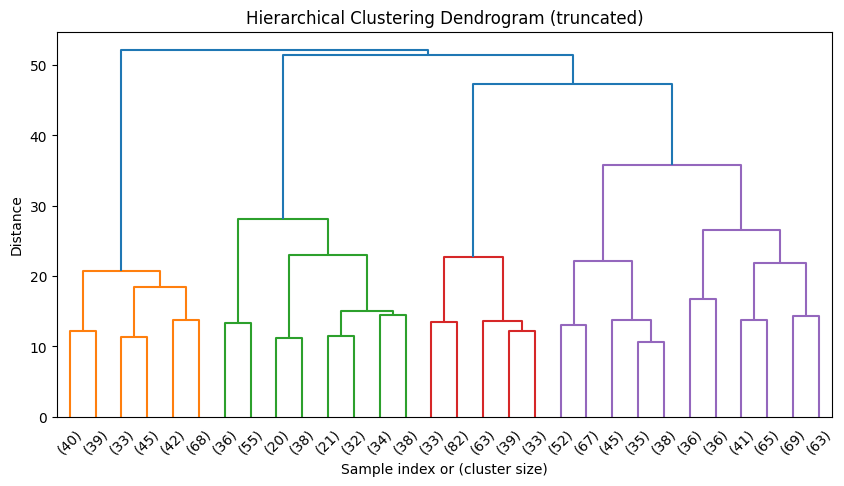

In [9]:
linked = linkage(X_scaled, method='ward')

plt.figure(figsize=(10, 5))
dendrogram(linked, truncate_mode='lastp', p=30)
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('Sample index or (cluster size)')
plt.ylabel('Distance')
plt.show()

# Agglomerative clustering (Ward linkage)
agglo = AgglomerativeClustering(n_clusters=4)
df_encoded['Cluster_Hierarchical'] = agglo.fit_predict(X_scaled)


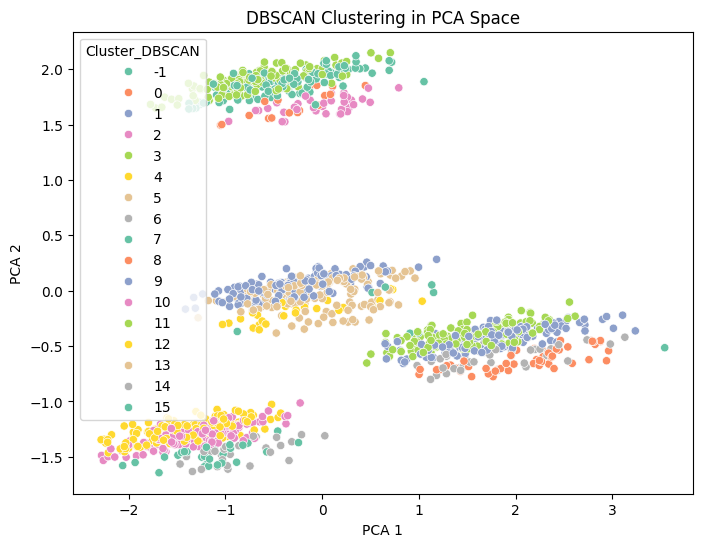

In [10]:
dbscan = DBSCAN(eps=1.5, min_samples=5)
df_encoded['Cluster_DBSCAN'] = dbscan.fit_predict(X_scaled)

# Visualize DBSCAN
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df_encoded['Cluster_DBSCAN'], palette='Set2')
plt.title('DBSCAN Clustering in PCA Space')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

In [11]:
df_clusters = df.copy()
df_clusters['Cluster'] = df_encoded['Cluster_KMeans']
df_clusters['charges'] = charges

# Compare average charges by cluster
cluster_summary = df_clusters.groupby('Cluster').agg({
    'age': 'mean',
    'bmi': 'mean',
    'children': 'mean',
    'charges': ['mean', 'count'],
    'smoker': lambda x: x.value_counts().idxmax(),
    'region': lambda x: x.value_counts().idxmax()
})

print("Cluster Summary:\n", cluster_summary)

Cluster Summary:
                age        bmi  children       charges         smoker  \
              mean       mean      mean          mean count <lambda>   
Cluster                                                                
0        39.268519  29.173503  1.046296  13406.384516   324       no   
1        39.196923  29.199785  1.147692  12417.575374   325       no   
2        39.455385  30.596615  1.141538  12346.937377   325       no   
3        38.939560  33.355989  1.049451  14735.411438   364       no   

            region  
          <lambda>  
Cluster             
0        northeast  
1        northwest  
2        southwest  
3        southeast  


/tmp/ipython-input-12-1117011349.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y='charges', data=df_clusters, palette='Pastel1')


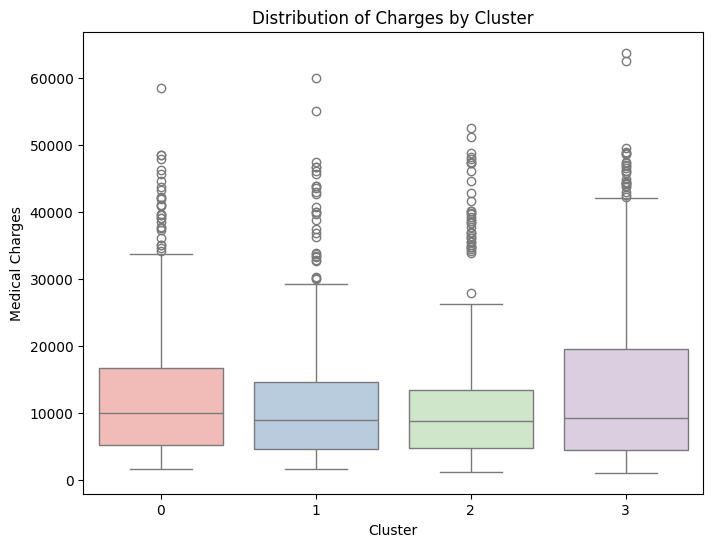

In [12]:
plt.figure(figsize=(8,6))
sns.boxplot(x='Cluster', y='charges', data=df_clusters, palette='Pastel1')
plt.title('Distribution of Charges by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Medical Charges')
plt.show()
